In [1]:
from src.evaluation.run import performance

In [2]:
perf_svm = performance('linear_svm', {'C': 0.04773295631615594,
  'max_iter': 5000,
  'dual': True,
  'class_weight': {0: 1.0, 1: 2.2, 2: 2.1, 3: 2.4, 4: 2.7, 5: 1.8, 6: 7.6},
  'random_state': 1000}, big=True)

(61302, 233075)


In [ ]:
perf_svm

{'aggregated': {'precision_macro': 0.7232505043136442,
  'recall_macro': 0.7547220510054756,
  'f1_macro': 0.7348762037777813},
 'per_class': {'precision': array([0.77453581, 0.75108225, 0.84552476, 0.64321926, 0.81945163,
         0.60148883, 0.62745098]),
  'recall': array([0.76943347, 0.8414161 , 0.85760369, 0.54776039, 0.94005935,
         0.50061958, 0.82616179]),
  'f1': array([0.77197621, 0.7936871 , 0.85152139, 0.59166424, 0.87562189,
         0.54643823, 0.71322437]),
  'support': array([4554, 2062, 2170, 1853, 1685, 2421,  581])},
 'confusion_matrix': array([[3504,  176,   71,  195,   53,  467,   88],
        [  76, 1735,   89,   53,   26,   54,   29],
        [  83,  110, 1861,   54,    9,   26,   27],
        [ 224,  117,  102, 1015,  128,  205,   62],
        [  25,    8,    3,   41, 1584,   22,    2],
        [ 590,  146,   69,  200,  127, 1212,   77],
        [  22,   18,    6,   20,    6,   29,  480]])}

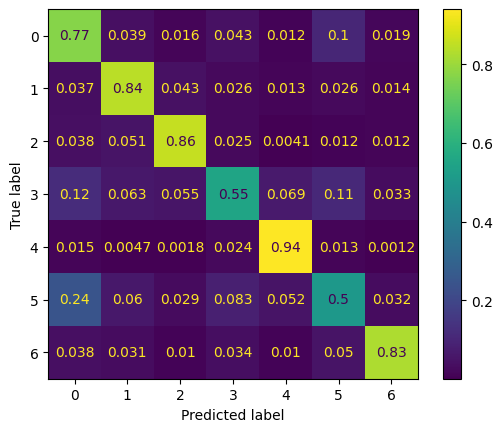

In [ ]:
conf_matr = perf_svm['confusion_matrix']
cm_norm = conf_matr / conf_matr.sum(axis=1, keepdims=True)
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=range(0,7), cmap)
disp.plot();

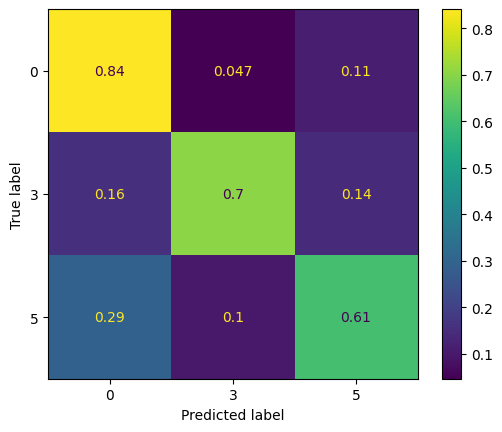

In [7]:
import numpy as np
idx = [0, 3, 5]
sub_cm = conf_matr[np.ix_(idx, idx)]
sub_cm = sub_cm / sub_cm.sum(axis=1, keepdims=True)

disp = ConfusionMatrixDisplay(confusion_matrix=sub_cm,
                              display_labels=[0,3,5])

disp.plot();

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import f1_score
from sklearn.base import clone

from src.preprocessing import build_preprocess
from src.config import SEED

def tune_k_for_target_classes(
    X_df, y,
    base_clf,
    target_labels,
    numeric_cols,
    k_grid=(100, 500, 1000, 2000, 5000, 10000, 30000, 70000, 100000, 200000),
    cv_splits=3,
    random_state=SEED,
    scoring_mix=(0.7, 0.3),
    return_all=True,
):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    all_results = []
    best = {"k": None, "score": -np.inf, "details": None}

    for k in k_grid:
        fold_scores = []
        fold_target = []
        fold_macro = []
        fold_f1_complete = []

        for tr_idx, va_idx in skf.split(X_df, y):
            Xtr, Xva = X_df.iloc[tr_idx], X_df.iloc[va_idx]
            ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]

            text_prep = build_preprocess("chi2_test", big=True, svd=False)

            extras_prep = ColumnTransformer(
                transformers=[
                    ("source", OneHotEncoder(handle_unknown="ignore"), ["source"]),
                    ("num", StandardScaler(), numeric_cols),
                ],
                remainder="drop"
            )

            text_branch = Pipeline([
                ("prep", text_prep),
                ("fs", SelectKBest(chi2, k=k)),
            ])

            full_features = FeatureUnion([
                ("text", text_branch),
                ("extras", extras_prep),
            ])

            pipe = Pipeline([
                ("features", full_features),
                ("clf", clone(base_clf)),
            ])

            try:
                pipe.fit(Xtr, ytr)
                pred = pipe.predict(Xva)
            except ValueError:
                continue

            target_f1 = f1_score(yva, pred, labels=target_labels, average="macro", zero_division=0)
            macro_f1 = f1_score(yva, pred, average="macro", zero_division=0)
            score = scoring_mix[0] * target_f1 + scoring_mix[1] * macro_f1

            fold_scores.append(score)
            fold_target.append(target_f1)
            fold_macro.append(macro_f1)
            fold_f1_complete.append(f1_score(yva, pred, average=None, zero_division=0))

        if len(fold_scores) == 0:
            all_results.append({
                "k": k,
                "score": float("-inf"),
                "details": {
                    "target_f1": float("nan"),
                    "macro_f1": float("nan"),
                    "n_folds_ok": 0,
                    "score_std": float("nan"),
                    "target_f1_std": float("nan"),
                    "macro_f1_std": float("nan"),
                }
            })
            continue

        mean_score = float(np.mean(fold_scores))
        mean_target = float(np.mean(fold_target))
        mean_macro = float(np.mean(fold_macro))

        res = {
            "k": k,
            "score": mean_score,
            "details": {
                "single_f1": np.mean(fold_f1_complete, axis=0),
                "target_f1": mean_target,
                "macro_f1": mean_macro,
                "n_folds_ok": len(fold_scores),
                "score_std": float(np.std(fold_scores, ddof=1)) if len(fold_scores) > 1 else 0.0,
                "target_f1_std": float(np.std(fold_target, ddof=1)) if len(fold_target) > 1 else 0.0,
                "macro_f1_std": float(np.std(fold_macro, ddof=1)) if len(fold_macro) > 1 else 0.0,
            }
        }
        all_results.append(res)

        if mean_score > best["score"]:
            best = {"k": k, "score": mean_score, "details": res["details"]}

    all_results_sorted = sorted(all_results, key=lambda d: d["score"], reverse=True)

    if return_all:
        return best, all_results_sorted
    return best

In [2]:
from sklearn.svm import LinearSVC
from src.utils import load_data
from src.config import *

numeric_cols = [
    "page_rank",
    "timestamp_missing",
    "year",
    "len_article",
    "len_title",
    "dayofweek",
    "month",
    "hour"
]

params = {'C': 0.04773295631615594,
  'max_iter': 5000,
  'dual': True,
  'class_weight': {0: 1.0, 1: 2.2, 2: 2.1, 3: 2.4, 4: 2.7, 5: 1.8, 6: 7.6},
  'random_state': 1000}
base_clf = LinearSVC(**params)

news_df = load_data(DEVELOPMENT_PATH)

X = news_df.drop(columns=['y'])
y = news_df['y']


In [3]:
best_lsvm, all_lsvm = tune_k_for_target_classes(X, y, base_clf, numeric_cols=numeric_cols, target_labels=[0,3,5])


In [4]:
best_lsvm

{'k': 70000,
 'score': 0.6640108180350889,
 'details': {'single_f1': array([0.77513947, 0.78895616, 0.84055032, 0.58751102, 0.87113343,
         0.54683719, 0.68735859]),
  'target_f1': 0.6364958923374453,
  'macro_f1': 0.728212311329591,
  'n_folds_ok': 3,
  'score_std': 0.0017049381672769339,
  'target_f1_std': 0.0023779475768489185,
  'macro_f1_std': 0.0020225078562975296}}

In [5]:
all_lsvm

[{'k': 70000,
  'score': 0.6640108180350889,
  'details': {'single_f1': array([0.77513947, 0.78895616, 0.84055032, 0.58751102, 0.87113343,
          0.54683719, 0.68735859]),
   'target_f1': 0.6364958923374453,
   'macro_f1': 0.728212311329591,
   'n_folds_ok': 3,
   'score_std': 0.0017049381672769339,
   'target_f1_std': 0.0023779475768489185,
   'macro_f1_std': 0.0020225078562975296}},
 {'k': 200000,
  'score': 0.6638457125446688,
  'details': {'single_f1': array([0.77447186, 0.78801102, 0.83943675, 0.58586454, 0.87167318,
          0.54883915, 0.68703662]),
   'target_f1': 0.6363918483818977,
   'macro_f1': 0.7279047289244686,
   'n_folds_ok': 3,
   'score_std': 0.001643835445344738,
   'target_f1_std': 0.0024318244812648344,
   'macro_f1_std': 0.0015664108225348504}},
 {'k': 100000,
  'score': 0.6636283043076912,
  'details': {'single_f1': array([0.77432198, 0.78975514, 0.84026417, 0.58694457, 0.87181354,
          0.54682982, 0.68620652]),
   'target_f1': 0.6360321244788422,
   'm

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from src.preprocessing import build_preprocess


def build_stacking_model(
    base_clf,
    k_values,
    numeric_cols,
    include_full=True,
    big=True,
    scale_numeric=True,
    stack_cv=5,
    final_estimator=None,
    n_jobs=-1,
):
    if final_estimator is None:
        final_estimator = LogisticRegression(max_iter=5000)

    estimators = []

    for k in k_values:
        text_prep = build_preprocess("chi2_test", big=big, svd=False)
        extras_prep = ColumnTransformer(
            transformers=[
                ("source", OneHotEncoder(handle_unknown="ignore"), ["source"]),
                ("num", StandardScaler() if scale_numeric else "passthrough", numeric_cols),
            ],
            remainder="drop"
        )

        text_branch = Pipeline([
            ("prep", text_prep),
            ("fs", SelectKBest(chi2, k=k)),
        ])

        features = FeatureUnion([
            ("text", text_branch),
            ("extras", extras_prep),
        ])
        est = Pipeline([
            ("features", features),
            ("clf", clone(base_clf)),
        ])
        estimators.append((f"base_k{k}", est))

    if include_full:
        features_full = build_preprocess("linear_svm", big=big, svd=False)
        est_full = Pipeline([
            ("features", features_full),
            ("clf", clone(base_clf)),
        ])
        estimators.append(("base_full", est_full))

    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=stack_cv,                 
        stack_method="predict_proba",
        n_jobs=n_jobs,
        passthrough=False,
    )
    return stack


In [7]:

k_values = [5000, 70000, 100000]
params = {'C': 0.04773295631615594,
  'max_iter': 5000,
  'dual': True,
  'class_weight': {0: 1.0, 1: 2.2, 2: 2.1, 3: 2.4, 4: 2.7, 5: 1.8, 6: 7.6},
  'random_state': 1000}
from sklearn.calibration import CalibratedClassifierCV
base_clf = CalibratedClassifierCV(
    LinearSVC(**params),
    cv=3,
    method="sigmoid"
)

numeric_cols = [
    "page_rank",
    "timestamp_missing",
    "year",
    "len_article",
    "len_title",
    "dayofweek",
    "month",
    "hour"
]
stack = build_stacking_model(base_clf, k_values, numeric_cols)

In [ ]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X = news_df.drop(columns=['y'])
y = news_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

stack.fit(X_train, y_train)
pred = stack.predict(X_test)

print("STACK macro-F1:", f1_score(y_test, pred, average="macro"))
print("STACK target-F1:", f1_score(y_test, pred, labels=[0,3,5],average="macro", zero_division=0))
print(classification_report(y_test, pred, zero_division=0))


STACK macro-F1: 0.7232313005708538
STACK target-F1: 0.6224930230227242
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      4554
           1       0.78      0.80      0.79      2062
           2       0.85      0.85      0.85      2170
           3       0.61      0.53      0.57      1853
           4       0.84      0.91      0.87      1685
           5       0.60      0.46      0.52      2421
           6       0.69      0.67      0.68       581

    accuracy                           0.74     15326
   macro avg       0.73      0.72      0.72     15326
weighted avg       0.73      0.74      0.73     15326



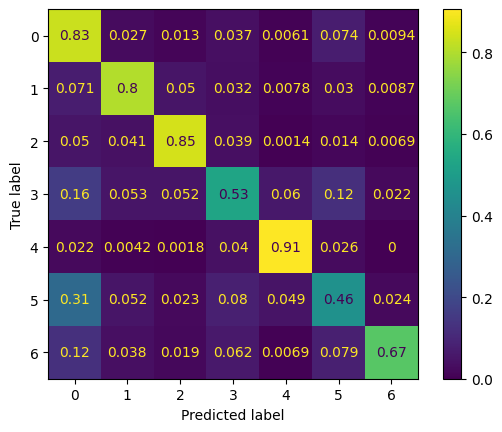

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=range(0,7))
disp.plot();